# Run level 2A, 2B and 3 pipelines on MRS data using jwst.pipeline classes

### by Patrick Kavanagh (DIAS, Ireland) Dec 5th 2017

This notebook demonstrates the execution of the level 2A, 2B, and 3 pipelines for MRS data in Python using the jwst.pipeline classes.

For a description of the pipeline classes see:

https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/index.html

The files used in this notebook is a MIRISim simulation of a point source with power-law (alpha=0) plus emission lines spectrum. The simulated observation is a four-point dither on the source with the channels 1 and 2, and the SHORT disperser. 

The steps applied are:

- ramps to slopes pipeline (Detector1Pipeline)

- CALSPEC2 steps and spectral extraction from each dither (Spec2Pipeline)

- combination of dithers and spectral extraction (Tso3Pipeline)

- manual conversion of extracted spectra to Jy 


#### Imports

In [1]:
import os, glob, shutil

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call

from jwst import datamodels

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input, output location and source type
Since we know the simulation is of a point source, we can set the source type metadata to 'POINT' at this stage as that information is used later in spectral extraction. Otherwise, the pipeline will set the default source type for MRS which is 'EXTENDED'

In [2]:
# set input filenames and directory. In this example, the files are located in a folder called 'MRS_demo_data'
input_dir = 'MRS_demo_data'
input_files = glob.glob(os.path.join(input_dir,'*.fits'))

# set the source type as 'POINT'
for f in input_files:
    with datamodels.MIRIRampModel(f) as dm:
        dm.meta.target.source_type = 'POINT'
        dm.save(os.path.join(input_dir, dm.meta.filename))

# set the output directory name
output_dir = input_dir + '_pipelined'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input files. We will just look at the first file

In [3]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:
    
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['DETECTOR']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t\t\t\t Detector\t nInts\t nGrps\t rdPatt\t subAr\t chan.\t band")
        print("--------------------------------------------------------------------------------------------------")
        print("%s\t %s\t %d\t %s\t %s\t %s\t %s\t %s" % (identifier,detector,nInts,nGroups,readPatt,subArr,channel,band))
        print("\n\n")
        
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['DETECTOR']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print("ID\t Detector\t nInts\t nGrps\t rdPatt\t chan.\t band")
        print("--------------------------------------------------------------------------------------------------")
        print("MIRISim\t %s\t %d\t %s\t %s\t %s\t %s" % (detector,nInts,nGroups,readPatt,channel,band))
        print("\n\n")

    # fits extension table
    hdulist.info()

ID	 Detector	 nInts	 nGrps	 rdPatt	 chan.	 band
--------------------------------------------------------------------------------------------------
MIRISim	 MIRIFUSHORT	 2	 50	 FAST	 12	 SHORT



Filename: MRS_demo_data/det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     107   ()      
  1  SCI           1 ImageHDU        62   (1032, 1024, 50, 2)   float32   
  2  PIXELDQ       1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ       1 ImageHDU        11   (1032, 1024, 50, 2)   uint8   
  4  ERR           1 ImageHDU        11   (1032, 1024, 50, 2)   float32   
  5  REFOUT        1 ImageHDU        12   (258, 1024, 50, 2)   float32   
  6  PIXELDQ_DEF    1 BinTableHDU     17   29R x 4C   [J, J, 40A, 128A]   
  7  ASDF          1 ImageHDU         7   (11094,)   uint8   


#### show the last frame of the first integration for each file

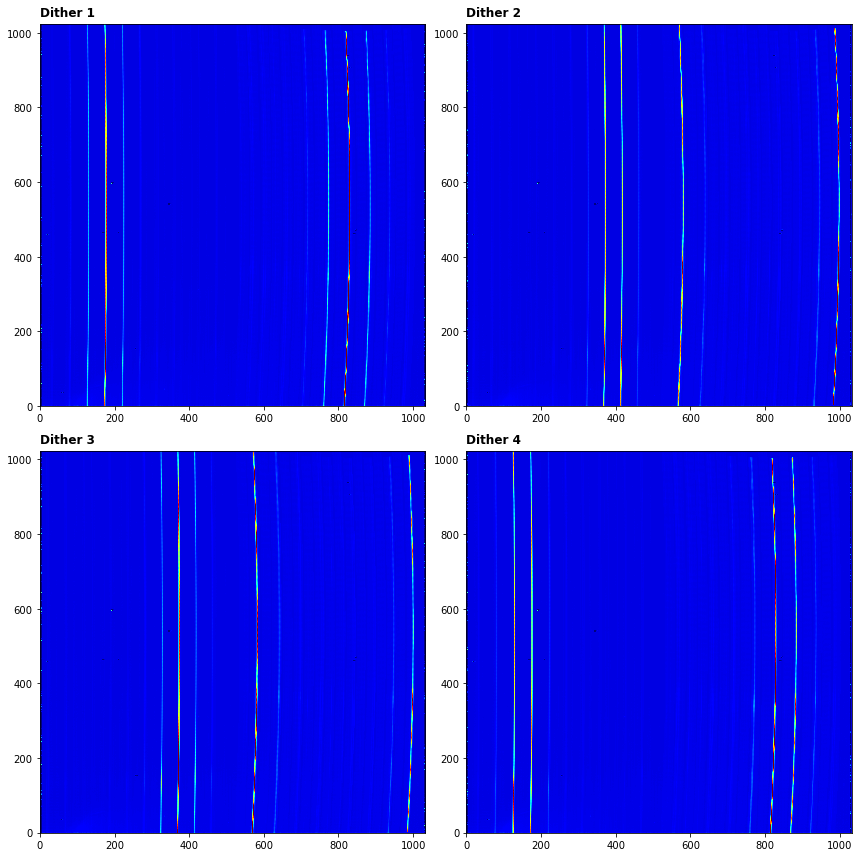

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()

i = 0
for f in input_files:
    # open the input image as a jwst data model
    with datamodels.MIRIRampModel(f) as in_dm:

        dith_num = i+1
        axs[i].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=3e4))
        axs[i].annotate('Dither %d' % dith_num, xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[i].set_facecolor('black')
        i += 1

plt.tight_layout()
plt.show()

### Level 2A pipeline (ramps-to-slopes)

#### import the level 2A pipeline class and print description

In [5]:
from jwst.pipeline import Detector1Pipeline
print(Detector1Pipeline.__doc__)



    Detector1Pipeline: Apply all calibration steps to raw JWST
    ramps to produce a 2-D slope product. Included steps are:
    group_scale, dq_init, saturation, ipc, superbias, refpix, rscd,
    lastframe, linearity, dark_current, persistence, jump detection,
    ramp_fit, and gain_scale.

    


#### run pipeline
We pass the level 1B files (demo data). The output level 2A files will be saved in the output_dir as '*_rate.fits'


In [6]:
for f in input_files:
    dm = datamodels.open(f)
    Detector1Pipeline.call(dm, save_results=True, output_dir=output_dir)


2017-12-11 13:54:51,069 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2017-12-11 13:54:51,070 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2017-12-11 13:54:51,072 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2017-12-11 13:54:51,073 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2017-12-11 13:54:51,074 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2017-12-11 13:54:51,076 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2017-12-11 13:54:51,077 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2017-12-11 13:54:51,079 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2017-12-11 13:54:51,080 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2017-12-11 13:54:51,082 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2017-12-11 13

2017-12-11 13:55:45,819 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0
2017-12-11 13:55:54,959 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done
2017-12-11 13:55:55,116 - stpipe.Detector1Pipeline.refpix - INFO - Prefetch for REFPIX reference file is 'N/A'.
2017-12-11 13:55:55,172 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<jwst.datamodels.ramp.RampModel object at 0x158067fd0>,).
2017-12-11 13:55:55,196 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True
2017-12-11 13:55:55,197 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True
2017-12-11 13:55:55,198 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11
2017-12-11 13:55:55,198 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000
2017-12-11 13:55:55,199 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True
2017-12-11 13:55:55,864 - stpipe.Detector1Pipeline.ref

2017-12-11 13:59:28,529 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2017-12-11 13:59:28,531 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2017-12-11 13:59:28,533 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2017-12-11 13:59:28,535 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2017-12-11 13:59:28,536 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2017-12-11 13:59:28,538 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2017-12-11 13:59:28,540 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2017-12-11 13:59:28,542 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2017-12-11 13:59:28,543 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2017-12-11 13:59:28,545 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2017-12-11 

2017-12-11 14:00:27,733 - stpipe.Detector1Pipeline.refpix - INFO - use_side_ref_pixels = True
2017-12-11 14:00:27,733 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_columns = True
2017-12-11 14:00:27,734 - stpipe.Detector1Pipeline.refpix - INFO - side_smoothing_length = 11
2017-12-11 14:00:27,735 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000
2017-12-11 14:00:27,736 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True
2017-12-11 14:00:28,386 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration
2017-12-11 14:00:29,750 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in
2017-12-11 14:00:30,797 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2017-12-11 14:00:30,943 - stpipe.Detector1Pipeline.jump - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits'.
2017-12-11 14:00:30,944 - stpipe.Detector1Pipeline.jump - INFO - Pr

2017-12-11 14:03:59,346 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2017-12-11 14:03:59,347 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2017-12-11 14:03:59,349 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2017-12-11 14:03:59,350 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2017-12-11 14:03:59,352 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2017-12-11 14:03:59,354 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2017-12-11 14:03:59,537 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_dark_0056.fits'.
2017-12-11 14:03:59,538 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits'.
2017-12-11 14:03:59,539 - stpip

2017-12-11 14:05:02,126 - stpipe.Detector1Pipeline.refpix - INFO - Subtracting initial read from each integration
2017-12-11 14:05:03,508 - stpipe.Detector1Pipeline.refpix - INFO - Adding initial read back in
2017-12-11 14:05:04,517 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2017-12-11 14:05:04,642 - stpipe.Detector1Pipeline.jump - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits'.
2017-12-11 14:05:04,643 - stpipe.Detector1Pipeline.jump - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits'.
2017-12-11 14:05:04,703 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<jwst.datamodels.ramp.RampModel object at 0x211a91978>,).
2017-12-11 14:05:04,769 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2017-12-11 14:05:04,841 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN r

2017-12-11 14:08:49,467 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2017-12-11 14:08:49,639 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_dark_0056.fits'.
2017-12-11 14:08:49,640 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits'.
2017-12-11 14:08:49,641 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_ipc_0008.fits'.
2017-12-11 14:08:49,642 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0023.fits'.
2017-12-11 14:08:49,642 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0

2017-12-11 14:09:53,515 - stpipe.Detector1Pipeline.jump - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits'.
2017-12-11 14:09:53,573 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<jwst.datamodels.ramp.RampModel object at 0x158067a58>,).
2017-12-11 14:09:53,636 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma
2017-12-11 14:09:53,696 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0007.fits
2017-12-11 14:09:53,798 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0034.fits
2017-12-11 14:09:55,016 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method
2017-12-11 14:10:06,731 - stpipe.Detector1Pipeline.jump - INFO - Step jump done
2017-12-11 14:10

#### Quick check of the pipeline steps applied in the output. We'll look at the first dither:

In [7]:
level2A_files = glob.glob(os.path.join(output_dir,'*_rate.fits'))

with datamodels.open(level2A_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('dq_init: %s' % dm.meta.cal_step.dq_init)
    print('saturation: %s' % dm.meta.cal_step.saturation)
    print('ipc: %s' % dm.meta.cal_step.ipc)
    print('linearity: %s' % dm.meta.cal_step.linearity)
    print('rscd: %s' % dm.meta.cal_step.rscd)
    print('lastframe: %s' % dm.meta.cal_step.lastframe)
    print('dark_current: %s' % dm.meta.cal_step.dark_sub)
    print('refpix: %s' % dm.meta.cal_step.refpix)
    print('jump: %s' % dm.meta.cal_step.jump)
    print('ramp_fit: %s' % dm.meta.cal_step.ramp_fit)

Check step information status:
dq_init: COMPLETE
saturation: COMPLETE
ipc: COMPLETE
linearity: COMPLETE
rscd: COMPLETE
lastframe: COMPLETE
dark_current: COMPLETE
refpix: COMPLETE
jump: COMPLETE
ramp_fit: COMPLETE


### Level 2B pipeline

#### import the level 2B pipeline class and print description

In [8]:
from jwst.pipeline import Spec2Pipeline
print(Spec2Pipeline.__doc__)


    Spec2Pipeline: Processes JWST spectroscopic exposures from Level 2a to 2b.
    Accepts a single exposure or an association as input.

    Included steps are:
    assign_wcs, background subtraction, NIRSpec MSA imprint subtraction,
    NIRSpec MSA bad shutter flagging, 2-D subwindow extraction, flat field,
    source type decision, straylight, fringe, pathloss, barshadow,  photom,
    resample_spec, cube_build, and extract_1d.
    


#### run pipeline
We pass the level 2A files. The output level 2B files will be saved in the output_dir as '*_cal.fits'. 

Note that since MIRISim does not add straylight, we can skip the straylight correction step.

In [9]:
for f in level2A_files:
    Spec2Pipeline.call(f, save_results=True, output_dir=output_dir, steps={'straylight':{'skip':True}})


2017-12-11 14:13:26,697 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2017-12-11 14:13:26,700 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2017-12-11 14:13:26,703 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2017-12-11 14:13:26,704 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2017-12-11 14:13:26,705 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2017-12-11 14:13:26,708 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2017-12-11 14:13:26,711 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2017-12-11 14:13:26,713 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.
2017-12-11 14:13:26,714 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.
2017-12-11 14:13:26,715 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.
2017-12-11 14:13:2

2017-12-11 14:13:27,752 - stpipe.Spec2Pipeline.assign_wcs - INFO - Prefetch for WAVELENGTHRANGE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_wavelengthrange_0003.asdf'.
2017-12-11 14:13:27,804 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<jwst.datamodels.image.ImageModel object at 0x15744bf28>,).
2017-12-11 14:13:35,824 - stpipe.Spec2Pipeline.assign_wcs - INFO - assign_wcs did not update S_REGION for type MIR_MRS
2017-12-11 14:13:35,825 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2017-12-11 14:13:36,064 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2017-12-11 14:13:36,542 - stpipe.Spec2Pipeline.flat_field - INFO - Prefetch for DFLAT reference file is 'N/A'.
2017-12-11 14:13:36,543 - stpipe.Spec2Pipeline.flat_field - INFO - Prefetch for FFLAT reference file is 'N/A'.
2017-12-11 14:13:36,543 - stpipe.Spec2Pipeline.flat_field - INFO - Prefetch for FLAT reference file is '/Users/p

2017-12-11 14:13:47,381 - stpipe.Spec2Pipeline.cube_build - INFO - axis# Naxis  CRPIX    CRVAL      CDELT(arc sec)  MIN & Max (xi,eta arc sec)
2017-12-11 14:13:47,382 - stpipe.Spec2Pipeline.cube_build - INFO - Axis 1    42  22.00  -0.00034857   0.13000000  -2.79499990   2.79499990
2017-12-11 14:13:47,383 - stpipe.Spec2Pipeline.cube_build - INFO - Axis 2    40  21.00  -0.00019485   0.13000000  -2.66499990   2.66499990
2017-12-11 14:13:47,384 - stpipe.Spec2Pipeline.cube_build - INFO - Axis 3  1612   1.00   4.84728560   0.00250000   4.84728560   8.87728551
2017-12-11 14:13:47,385 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 1 SHORT 
2017-12-11 14:13:47,386 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2 SHORT 
2017-12-11 14:13:47,386 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name det_image_seq1_MIRIFUSHORT_12SHORTexp1_s3d.fits
2017-12-11 14:15:02,232 - stpipe.Spec2Pipeline.cube_build - INFO - Time Map All slices on Detec

2017-12-11 14:15:11,070 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_wavelengthrange_0003.asdf'.
2017-12-11 14:15:11,171 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('MRS_demo_data_pipelined/det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits',).
2017-12-11 14:15:11,172 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...
2017-12-11 14:15:11,352 - stpipe.Spec2Pipeline - INFO - Processing product MRS_demo_data_pipelined/det_image_seq2_MIRIFUSHORT_12SHORTexp1
2017-12-11 14:15:11,352 - stpipe.Spec2Pipeline - INFO - Working on input MRS_demo_data_pipelined/det_image_seq2_MIRIFUSHORT_12SHORTexp1_rate.fits ...
2017-12-11 14:15:11,717 - stpipe.Spec2Pipeline.assign_wcs - INFO - Prefetch for CAMERA reference file is 'N/A'.
2017-12-11 14:15:11,718 - stpipe.Spec2Pipeline.assign_wcs - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2017-12-11 14:15:11,719 - stpip

2017-12-11 14:15:30,577 - stpipe.Spec2Pipeline.photom - INFO - Step photom done
2017-12-11 14:15:31,264 - stpipe.Spec2Pipeline.cube_build - INFO - Prefetch for CUBEPAR reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_cubepar_0001.fits'.
2017-12-11 14:15:31,265 - stpipe.Spec2Pipeline.cube_build - INFO - Prefetch for RESOL reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_resol_0003.fits'.
2017-12-11 14:15:31,417 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build running with args (<jwst.datamodels.image.ImageModel object at 0x1581515f8>,).
2017-12-11 14:15:31,418 - stpipe.Spec2Pipeline.cube_build - INFO - Starting IFU Cube Building Step
2017-12-11 14:15:31,419 - stpipe.Spec2Pipeline.cube_build - INFO - Input interpolation: pointcloud
2017-12-11 14:15:31,420 - stpipe.Spec2Pipeline.cube_build - INFO - Coordinate system to use: ra-dec
2017-12-11 14:15:31,421 - stpipe.Spec2Pipeline.cube_build - INFO - Weighting m

2017-12-11 14:16:57,096 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json'.
2017-12-11 14:16:57,097 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.
2017-12-11 14:16:57,098 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.
2017-12-11 14:16:57,098 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_flat_0248.fits'.
2017-12-11 14:16:57,099 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.
2017-12-11 14:16:57,100 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.
2017-12-11 14:16:57,101 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_fringe_0031.fits'.
2017-12-11 14:16:57,102 - stpipe.Spec2Pipeline - INFO 

2017-12-11 14:17:12,660 - stpipe.Spec2Pipeline.straylight - INFO - Step skipped.
2017-12-11 14:17:12,982 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight done
2017-12-11 14:17:13,771 - stpipe.Spec2Pipeline.fringe - INFO - Prefetch for FRINGE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_fringe_0031.fits'.
2017-12-11 14:17:13,971 - stpipe.Spec2Pipeline.fringe - INFO - Step fringe running with args (<jwst.datamodels.image.ImageModel object at 0x16ebb4668>,).
2017-12-11 14:17:14,489 - stpipe.Spec2Pipeline.fringe - INFO - Using FRINGE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_fringe_0031.fits
2017-12-11 14:17:14,550 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2017-12-11 14:17:14,551 - stpipe.Spec2Pipeline.fringe - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
201

2017-12-11 14:18:47,915 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2017-12-11 14:18:47,917 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2017-12-11 14:18:47,918 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2017-12-11 14:18:47,920 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2017-12-11 14:18:47,921 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2017-12-11 14:18:47,923 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.
2017-12-11 14:18:47,924 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2017-12-11 14:18:47,926 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.
2017-12-11 14:18:47,927 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.
2017-12-11 14:18:47,928 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.
2017-12-11 14:18:4

2017-12-11 14:18:49,400 - stpipe.Spec2Pipeline.assign_wcs - INFO - Prefetch for WAVELENGTHRANGE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_wavelengthrange_0003.asdf'.
2017-12-11 14:18:49,584 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<jwst.datamodels.image.ImageModel object at 0x17130d5f8>,).
2017-12-11 14:18:59,646 - stpipe.Spec2Pipeline.assign_wcs - INFO - assign_wcs did not update S_REGION for type MIR_MRS
2017-12-11 14:18:59,647 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2017-12-11 14:18:59,895 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done
2017-12-11 14:19:00,639 - stpipe.Spec2Pipeline.flat_field - INFO - Prefetch for DFLAT reference file is 'N/A'.
2017-12-11 14:19:00,640 - stpipe.Spec2Pipeline.flat_field - INFO - Prefetch for FFLAT reference file is 'N/A'.
2017-12-11 14:19:00,641 - stpipe.Spec2Pipeline.flat_field - INFO - Prefetch for FLAT reference file is '/Users/p

2017-12-11 14:19:13,669 - stpipe.Spec2Pipeline.cube_build - INFO - axis# Naxis  CRPIX    CRVAL      CDELT(arc sec)  MIN & Max (xi,eta arc sec)
2017-12-11 14:19:13,670 - stpipe.Spec2Pipeline.cube_build - INFO - Axis 1    42  22.00  -0.00031821   0.13000000  -2.79499990   2.79499990
2017-12-11 14:19:13,671 - stpipe.Spec2Pipeline.cube_build - INFO - Axis 2    40  21.00  -0.00017473   0.13000000  -2.66499990   2.66499990
2017-12-11 14:19:13,672 - stpipe.Spec2Pipeline.cube_build - INFO - Axis 3  1612   1.00   4.84728560   0.00250000   4.84728560   8.87728551
2017-12-11 14:19:13,673 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 1 SHORT 
2017-12-11 14:19:13,674 - stpipe.Spec2Pipeline.cube_build - INFO - Cube covers channel, subchannel: 2 SHORT 
2017-12-11 14:19:13,674 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name det_image_seq4_MIRIFUSHORT_12SHORTexp1_s3d.fits
2017-12-11 14:20:23,062 - stpipe.Spec2Pipeline.cube_build - INFO - Time Map All slices on Detec

### check of output

The level 2B pipeline for the MRS produces three files for each input:

_cal.fits - the calibrated level 2B file from each dither

_s3d.fits - the cube from each dither

_x1d.fits - the 1d spectrum from each dither


In [10]:
# set the output file names
level2B_files = glob.glob(os.path.join(output_dir,'*_cal.fits'))
cube_files = glob.glob(os.path.join(output_dir,'*_s3d.fits'))

#### level 2B file

In [11]:
with datamodels.open(level2B_files[0]) as dm:
    # check the calibration step information
    print('Check step information status:')
    print('assign_wcs: %s' % dm.meta.cal_step.assign_wcs)
    print('flat_field: %s' % dm.meta.cal_step.flat_field)
    print('straylight: %s' % dm.meta.cal_step.straylight)
    print('srctype: %s' % dm.meta.cal_step.srctype)
    print('fringe: %s' % dm.meta.cal_step.fringe)
    print('photom: %s' % dm.meta.cal_step.photom)


Check step information status:
assign_wcs: COMPLETE
flat_field: COMPLETE
straylight: None
srctype: COMPLETE
fringe: COMPLETE
photom: COMPLETE


#### Look at level 1B and calibrated level 2B image. We'll look at the first dither only

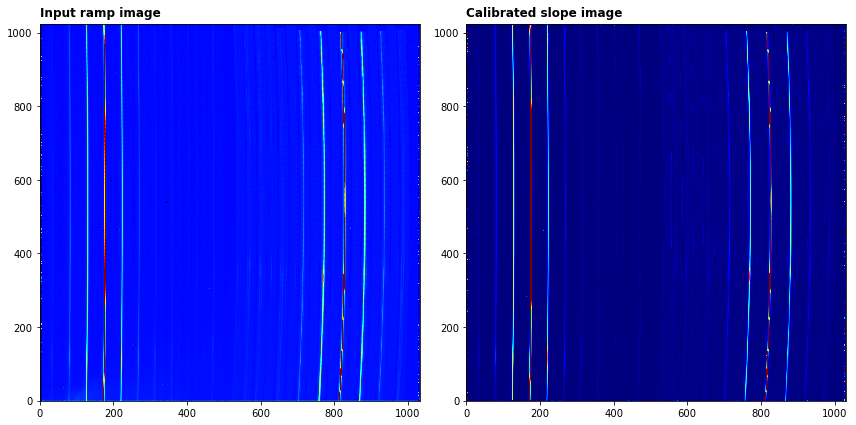

In [12]:
# open the input image as a jwst data model
with datamodels.MIRIRampModel(input_files[0]) as in_dm:
    with datamodels.open(level2B_files[0]) as out_dm:
        
        # plot--------------------------------------
        # show the input ramp image and the calibrated
        # slope image. Note the user may have to adjust
        # the scale parameters
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # sum the groups in the first integration of the input ramp image and plot
        axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=2e4))
        axs[0].annotate('Input ramp image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[0].set_facecolor('black')
        axs[1].imshow(out_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=0, vmax=500)
        axs[1].annotate('Calibrated slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[1].set_facecolor('black')

        plt.tight_layout()
        plt.show()

#### Look at cube file. We'll look at the first dither only

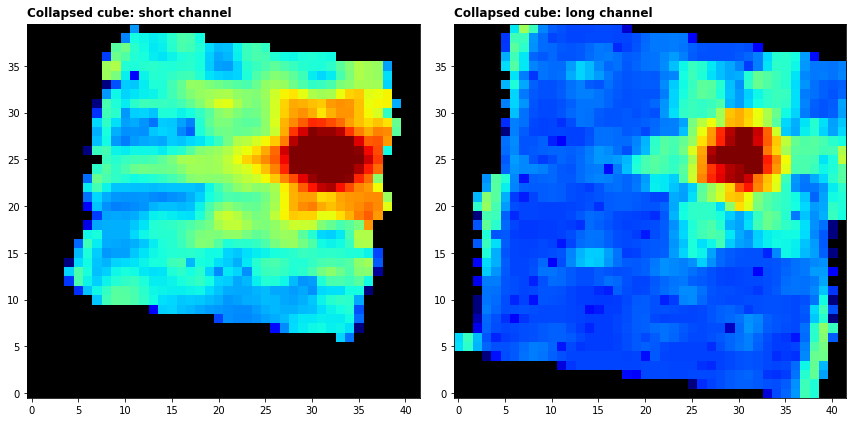

In [13]:
# open the cube as a jwst data model
with datamodels.open(cube_files[0]) as cube_dm:
    
    # plot--------------------------------------
    # sum some of the the frames in each channel
    # Note the user may have to adjust the scaling
    # parameters
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(np.sum(cube_dm.data[100:300], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=10,vmax=1e4))
    axs[0].annotate('Collapsed cube: short channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[0].set_facecolor('black')
    axs[1].imshow(np.sum(cube_dm.data[1200:1400], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=300,vmax=5e4))
    axs[1].annotate('Collapsed cube: long channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
    axs[1].set_facecolor('black')
    
    plt.tight_layout()
    plt.show()

### Level 3 pipeline

The Spec3Pipeline is not working in Build 7.1. There are a couple of issues which have been bumped to Build 7.2. These are:

1. outlier_detection does not work

2. extract_1d does not return a ModelContainer or save extracted spectra as it should and overwrites the cube files.

For now, we just use cube_build and extract_1d separate as standalone steps.

We first create an association file in the output directory containing the list of level 2B files ("_cal.fits") produced by the level 2B pipeline. 

#### create the level 3 association using the asn_from_list tool

In [14]:
call(["asn_from_list", "-o", "MRS_asn.json"] + level2B_files + ["--product-name", "dither"])


0

In [15]:
from jwst.cube_build import cube_build_step
cube_dms = cube_build_step.CubeBuildStep.call("MRS_asn.json", save_results=True, output_dir=output_dir)


2017-12-11 14:20:45,811 - stpipe.CubeBuildStep - INFO - CubeBuildStep instance created.
2017-12-11 14:20:51,834 - stpipe.CubeBuildStep - INFO - Prefetch for CUBEPAR reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_cubepar_0001.fits'.
2017-12-11 14:20:51,835 - stpipe.CubeBuildStep - INFO - Prefetch for RESOL reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_resol_0003.fits'.
2017-12-11 14:20:57,555 - stpipe.CubeBuildStep - INFO - Prefetch for CUBEPAR reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_cubepar_0001.fits'.
2017-12-11 14:20:57,556 - stpipe.CubeBuildStep - INFO - Prefetch for RESOL reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_resol_0003.fits'.
2017-12-11 14:21:03,115 - stpipe.CubeBuildStep - INFO - Prefetch for CUBEPAR reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_cubepar_0001.fits'.
2017-12-11

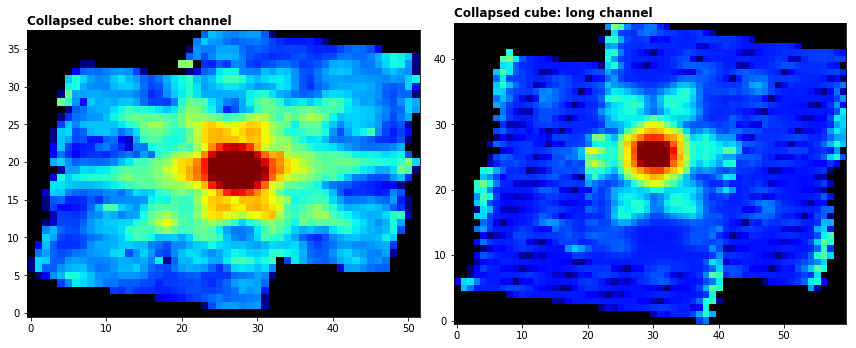

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(np.sum(cube_dms[0].data[100:-100], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=20,vmax=1e4))
axs[0].annotate('Collapsed cube: short channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].set_facecolor('black')
axs[1].imshow(np.sum(cube_dms[1].data[100:-100], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=300,vmax=5e4))
axs[1].annotate('Collapsed cube: long channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].set_facecolor('black')

plt.tight_layout()
plt.show()



In [17]:
from jwst.extract_1d import extract_1d_step
spec_dms = extract_1d_step.Extract1dStep.call(cube_dms, save_results=True, output_dir=output_dir, output_file='my_spectra.fits')


2017-12-11 14:24:47,604 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2017-12-11 14:24:48,571 - stpipe.Extract1dStep - INFO - Prefetch for EXTRACT1D reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json'.
2017-12-11 14:24:48,573 - stpipe.Extract1dStep - INFO - Prefetch for EXTRACT1D reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json'.
2017-12-11 14:24:49,068 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args (<jwst.datamodels.container.ModelContainer object at 0x11a2eb208>,).
2017-12-11 14:24:49,791 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0003.json
2017-12-11 14:24:49,845 - stpipe.Extract1dStep - INFO - source_type = point
2017-12-11 14:24:50,726 - stpipe.Extract1dStep - INFO - Data have been flux calibrated; setting net to 0.
2017-12-11 14:24:51,296

The extracted spectra are in units of mJy/arcsec^2. To convert these to mJy we multiply by the spaxel area. This is done before plotting:

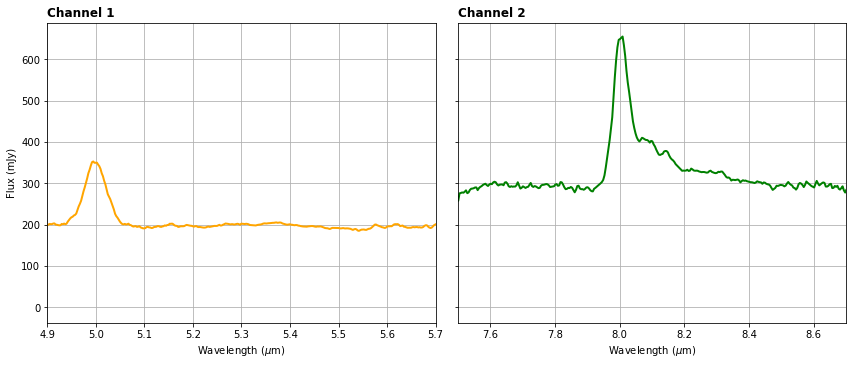

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# plot the spectrum in the channel 2 wavelength range
spaxel_area = cube_dms[0].meta.wcsinfo.cdelt1 * cube_dms[0].meta.wcsinfo.cdelt2 * 3600**2
axs[0].plot(spec_dms[0].spec[0].spec_table['WAVELENGTH'], spec_dms[0].spec[0].spec_table['FLUX'] * spaxel_area, c='orange', marker='.', markersize=0, linestyle='-', linewidth=2)
axs[0].set_ylabel(r'Flux (mJy)')
axs[0].set_xlabel(r'Wavelength ($\mu$m)')
axs[0].set_xlim(4.9,5.7)
#axs[0].set_ylim(0,2)
axs[0].annotate('Channel 1', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].grid()
spaxel_area = cube_dms[1].meta.wcsinfo.cdelt1 * cube_dms[1].meta.wcsinfo.cdelt2 * 3600**2
axs[1].plot(spec_dms[1].spec[0].spec_table['WAVELENGTH'], spec_dms[1].spec[0].spec_table['FLUX']  * spaxel_area, c='g', marker='.', markersize=0, linestyle='-', linewidth=2)
axs[1].set_xlabel(r'Wavelength ($\mu$m)')
axs[1].set_xlim(7.5,8.7)
axs[1].annotate('Channel 2', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].grid()

plt.tight_layout()
plt.show()